http://www.ece.northwestern.edu/local-apps/matlabhelp/toolbox/ident/ch1sip.html

In [46]:
% MEC 2015 System identification
% Prof Helon Ayala

% 01_MQB

pkg load control;
clc
clear
close all
rng(1) % permite reproducibilidade

In [47]:
% ---- code begins

%% - generate artificial data
% spring-mass-damper system

m = 0.1; b= 1; k = 10; % parameters
s = tf('s');
G = 1/(m*s^2+b*s+k); % continuous model
Ts = 0.01; % sampling time
Gd = c2d(G,Ts) % discrete model


Transfer function 'Gd' from input 'u1' to output ...

      0.0004833 z + 0.0004675
 y1:  -----------------------
      z^2 - 1.895 z + 0.9048 

Sampling time: 0.01 s
Discrete-time model.


In [48]:
th = [-1.895 0.9048 0.0004833 0.0004675]'; % true vector of parameters

% simulation parameters
N = 1000; % simulation steps
t = (1:N)'; % time vector
sig = 0.01; % noise corrupting measurements

In [49]:
% TRAINING
uamp = 10;
yr = 1;
u = uamp*ones(N,1);
y = zeros(N,1);

Dados de treinamento (UTRA e YTRA)

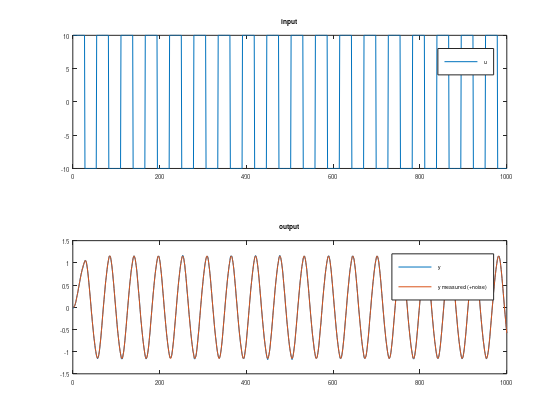

In [50]:
for k=3:N
    if y(k-1) >=  yr
        u(k) = -uamp;
    elseif y(k-1) <=  -yr
        u(k) = uamp;
    else
        u(k) = u(k-1);        
    end
    y(k) = -th(1)*y(k-1) + -th(2)*y(k-2) + th(3)*u(k-1) + th(4)*u(k-2);
end
UTRA = u;
YTRA = y + sig*randn(N,1);

% plot training data
figure
subplot(2,1,1)
plot(t,UTRA)
title('input')
legend('u');
subplot(2,1,2)
plot(t,[YTRA y])
title('output')
legend('y','y measured (+noise)');


Dados de validação (UVAL e YVAL)

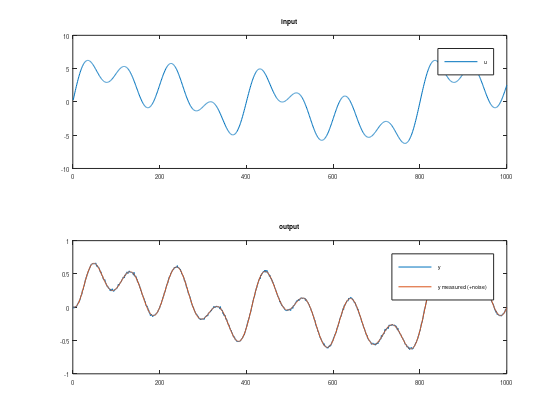

In [51]:
% VALIDATION
u = uamp/4*sin(2*pi*t*Ts) + uamp/4*sin(pi/2*t*Ts) + uamp/4*sin(pi*t*Ts) + uamp/4*sin(pi/4*t*Ts);
y = zeros(N,1);
for k=3:N
    y(k) = -th(1)*y(k-1) + -th(2)*y(k-2) + th(3)*u(k-1) + th(4)*u(k-2);
end
UVAL = u;
YVAL = y + sig*randn(N,1);

% plot validation data
figure
subplot(2,1,1)
plot(t,UVAL)
title('input')
legend('u');
subplot(2,1,2)
plot(t,[YVAL y])
title('output')
legend('y','y measured (+noise)');


___
Implementando a função `matreg`

In [125]:
function [Phi,yTARG] = matreg(y,u,na,nb)
    N = length(y);
    p = 1 + max(na,nb);
    Phi = [];

    if N<p  % tratando exceção do caso de N<p, caso da inicialização da simulação livre.
        Phi = [Phi; -y'(p-1:-1:p-na) u'(p-1:-1:p-nb)];
        yTARG = y(N);
    else
        for index = 0:N-p
            Phi = [Phi; -y'(p-1+index:-1:p-na+index) u'(p-1+index:-1:p-nb+index)];
        end
        yTARG = y(p:N);
    end
end

%%%%%%%%%%%%%%%%%%%%%%%%%%%% TESTE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% m=6;
% y_ = YTRA(1:m)'
% [Phi,yTARG] = matreg(YTRA(1:m),UTRA(1:m), 2, 2);
% Phi
% yTARG
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

y_ =

  -2.6665e-02  -7.3817e-03   2.4587e-02   3.3545e-02   4.8560e-02   7.8109e-02

Phi =

   7.3817e-03   2.6665e-02   1.0000e+01   1.0000e+01
  -2.4587e-02   7.3817e-03   1.0000e+01   1.0000e+01
  -3.3545e-02  -2.4587e-02   1.0000e+01   1.0000e+01
  -4.8560e-02  -3.3545e-02   1.0000e+01   1.0000e+01

yTARG =

   0.024587
   0.033545
   0.048560
   0.078109



Utilizando a função `matreg` acima

In [126]:
%% - perform identification
na=2;
nb=2;


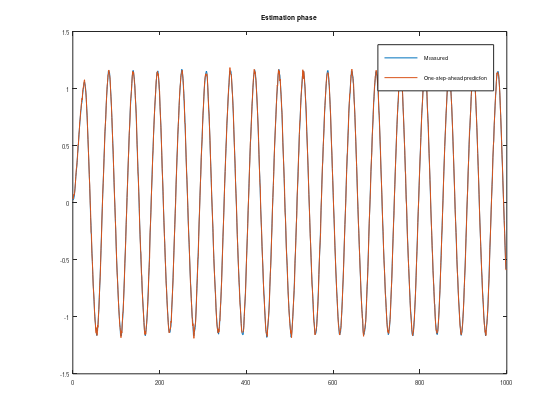

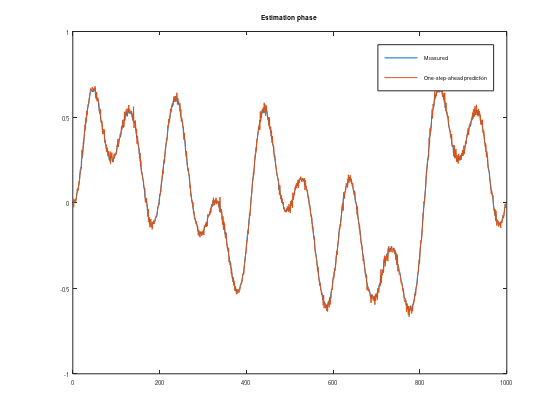

In [135]:
% construct regression matrix (using the matreg function)
[Phi, Y1] = matreg(YTRA, UTRA, na, nb);
[PhiVAL, Y2] = matreg(YVAL, UVAL, na, nb);

% estimate parameters:
th_hat = (Phi'*Phi)^(-1)*Phi'*Y1; % batch least squares

% one step ahead prediction
yhat_TRA_OSA = Phi*th_hat;
yhat_VAL_OSA = PhiVAL*th_hat;

figure
plot([Y1 yhat_TRA_OSA]), title('Estimation phase'), legend('Measured','One-step-ahead prediction')

figure
plot([Y2 yhat_VAL_OSA]), title('Estimation phase'), legend('Measured','One-step-ahead prediction')

Implementando a `simulação livre`

In [ ]:
function yhat_FS = freeSim(y,u,na,nb,th)
    p = 1 + max(na,nb);
    N = length(y);
    yhat_FS = [];
    
    y_temp = y(1:p-1);
    [Phi_k, ~] = matreg(y_temp, u(1:p-1), na, nb);
    yhat_k = Phi_k(end,:) * th;
    % shift circular no y_temp (remove o da esq e add no da direita)
    y_temp = [y_temp(2:end);yhat_k];
   
    % start predictions
    for k=p:N
        [Phi_k, ~] = matreg(y_temp, u(k-1:k), na, nb);
        yhat_k = Phi_k(end,:) * th;
        y_temp = [y_temp(2:end);yhat_k];
        % store predictions
        yhat_FS = [yhat_FS;yhat_k];
    end
end

%%%%%%%%%%%%%%%%%%%%%%%%%%%% TESTE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% m=N;
% y_ = YTRA(1:m)';
% y_pred = freeSim(YTRA(1:m),UTRA(1:m), na, nb, th_hat);
% plot(y_pred)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


In [132]:
% free run simulation 
yhat_TRA_FR = freeSim(YTRA,UTRA,na,nb,th_hat);
yhat_VAL_FR = freeSim(YVAL,UVAL,na,nb,th_hat);
length(yhat_TRA_FR)
length(yhat_VAL_FR)


ans = 998
ans = 998


max = 998


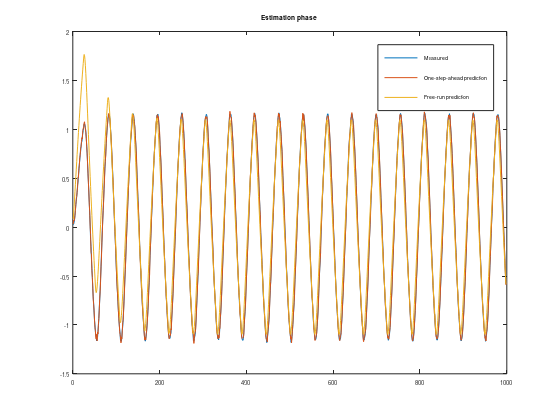

In [133]:
max=length(yhat_VAL_FR)

figure
plot([Y1(1:max) yhat_TRA_OSA(1:max) yhat_TRA_FR(1:max)])
title('Estimation phase')
legend('Measured','One-step-ahead prediction','Free-run prediction')


max = 992


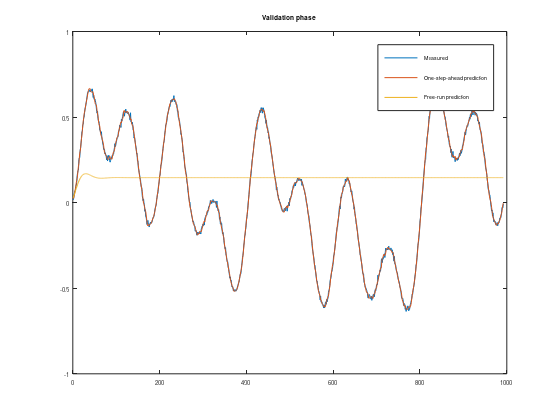

In [118]:
figure
plot([Y2(1:max) yhat_VAL_OSA(1:max) yhat_VAL_FR(1:max)])
title('Validation phase')
legend('Measured','One-step-ahead prediction','Free-run prediction')